In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# Use the following lines to test the basic functionality of the package if developing locally: 
import sys, os
sys.path.insert(0, "../src/")
from graph import *

This notebook showcases the first few steps of the Omics Integrator network analysis pipeline: 
1. Parameter selection
2. Randomization experiments

In order to use the inline R visualizations, please follow the setup instructions [here](https://www.datacamp.com/community/blog/jupyter-notebook-r).

In [2]:
# Load R plotting libraries

%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr)

array([1], dtype=int32)

In [3]:
%%R 

library(ComplexHeatmap)
library(circlize)
library(colorspace)

plotHeatmap <- function(nodes, node_attributes) {
"Visualizes a heatmap of summarized experiments generated by `summarize_grid_search`.

Arguments:
    nodes (df): Values summarized across experiments
    node_attributes (df): node attributes columns"
    
    # Get values to display parameter colorbars
    tmp <- data.frame(do.call(rbind, strsplit(colnames(nodes), '_', fixed=TRUE)))[,c(2,4,6)]
    colnames(tmp) <- c("w", "b", "g")
    indx <- sapply(tmp, is.factor)
    tmp[indx] <- lapply(tmp[indx], function(x) as.numeric(as.character(x)))
    tmp$g <- log10(tmp$g)
    
    node_attributes <- node_attributes_df[rownames(nodes),]

    # Top annotation
    ha = HeatmapAnnotation(
        df=node_attributes, 
        col=list(
            prize = colorRamp2(c(0,max(node_attributes$prize)), c("white", "orange")), 
            log_degree=colorRamp2(c(0,5,max(node_attributes$log_degree)), c("blue", "white", "red")), 
            type=c("steiner"="blue", "terminal"="red", "TF"="green")
        ), 
        annotation_legend_param=list(
            prize=list(legend_direction="horizontal"),
            log_degree=list(legend_direction="horizontal"),
            type=list(legend_direction="horizontal")
        )
    )

    ht = Heatmap(
        t(nodes), 
        name=" ", 
        col=c("white", "black"), 
        show_column_names=F, 
        top_annotation=ha, 
        top_annotation_height=unit(12, "mm")
    ) + 
        Heatmap(tmp$w, name="W", col=colorRamp2(c(0, max(tmp$w)), c("white", "red")), width=unit(6, "mm")) +
        Heatmap(tmp$b, name="B", col=colorRamp2(c(0, max(tmp$b)), c("white", "blue")), width=unit(6, "mm")) +
        Heatmap(tmp$g, name="G", col=colorRamp2(c(0, max(tmp$g)), c("white", "green")), width=unit(6, "mm"))

    draw(ht, heatmap_legend_side = "right", annotation_legend_side = "top")
}

# 0. Omics Integrator 2 Inputs

In [4]:
interactome_file = "/Users/jonathanli/Documents/research/ALS/data/interactome/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
prize_file = "/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/prizes.txt"
output_dir = "/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/"

Ws = [0.25, 0.5, 0.75, 1]
Bs = [0.25, 0.5, 0.75, 1]
Gs = [1000, 3000, 10000, 30000]

params = {
    "noise": 0.1, 
    "dummy_mode": "terminals", 
    "exclude_terminals": False, 
    "seed": 1
}

graph = Graph(interactome_file, params)
graph.prepare_prizes(prize_file)

01:47:56 - Graph: INFO - Duplicated edges in the interactome file (we'll keep the max cost):
01:47:56 - Graph: INFO - []
01:47:58 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
01:47:58 - Graph: INFO - ['HNRNPA2B1']
01:47:58 - Graph: INFO - Members of the prize file not present in the interactome:
01:47:58 - Graph: INFO - []


In [5]:
# Format of prize file
pd.read_csv(prize_file, sep='\t').head()

,name,prize,type
0,ANXA2,1.149461,terminal
1,ATM,0.453498,terminal
2,BDH2,0.472954,terminal
3,CBX1,0.895977,terminal
4,CBX3,0.479893,terminal


In [6]:
node_attributes_df = graph.node_attributes

# 1. Parameter sweep
First, d

In [7]:
results = graph.grid_search(prize_file, Ws, Bs, Gs)

01:48:02 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
01:48:02 - Graph: INFO - ['HNRNPA2B1']
01:48:02 - Graph: INFO - Members of the prize file not present in the interactome:
01:48:02 - Graph: INFO - []
01:48:03 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_1000
01:48:04 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_10000
01:48:04 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_1000
01:48:05 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_10000
01:48:05 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_3000
01:48:06 - Graph: INFO - Single PCSF runs for W_0.25_B_0.75_G_1000
01:48:06 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_30000
01:48:06 - Graph: INFO - Single PCSF runs for W_0.25_B_0.75_G_10000
01:48:07 - Graph: INFO - Single PCSF runs for W_0.25_B_1.00_G_1000
01:48:07 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_3000
01:48:07 - Graph: INFO - Single PCSF runs for W_0.25_B_1.00_G_10000
01:48:07 - Gr

In [8]:
membership_df = summarize_grid_search(results, "membership")

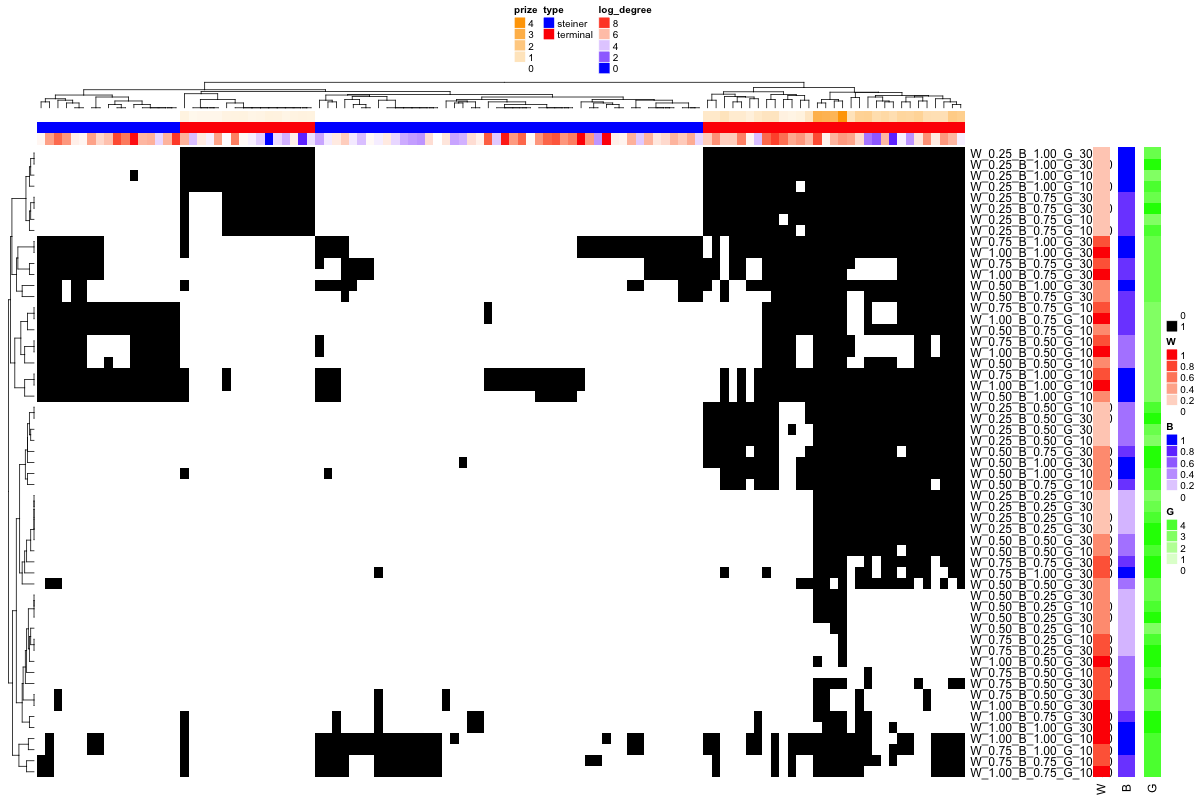

In [9]:
%%R -i membership_df,node_attributes_df -w 1200 -h 800 -u px

plotHeatmap(membership_df, node_attributes_df)

# 2. Randomization

In [10]:
results = graph.grid_randomization(prize_file, Ws, Bs, Gs, 5, 5)

01:48:30 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
01:48:30 - Graph: INFO - ['HNRNPA2B1']
01:48:30 - Graph: INFO - Members of the prize file not present in the interactome:
01:48:30 - Graph: INFO - []
01:48:32 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_1000
01:48:33 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_10000
01:48:34 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_1000
01:48:34 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_10000
01:48:35 - Graph: INFO - Randomizations for W_0.25_B_0.75_G_1000
01:48:35 - Graph: INFO - Randomizations for W_0.25_B_0.75_G_10000
01:48:36 - Graph: INFO - Randomizations for W_0.25_B_1.00_G_1000
01:48:36 - Graph: INFO - Randomizations for W_0.25_B_1.00_G_10000
01:48:38 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_3000
01:48:38 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_30000
01:48:39 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_3000
01:48:39 - Graph: INFO - Randomizat

In [11]:
for paramstring, forests in results.items(): 
    forests["robust"] = get_robust_subgraph_from_randomizations(forests["augmented_forest"], 400, 5)

In [12]:
robustness_df = summarize_grid_search(results, "robustness", top_n=1000)
specificity_df = summarize_grid_search(results, "specificity", top_n=1000)

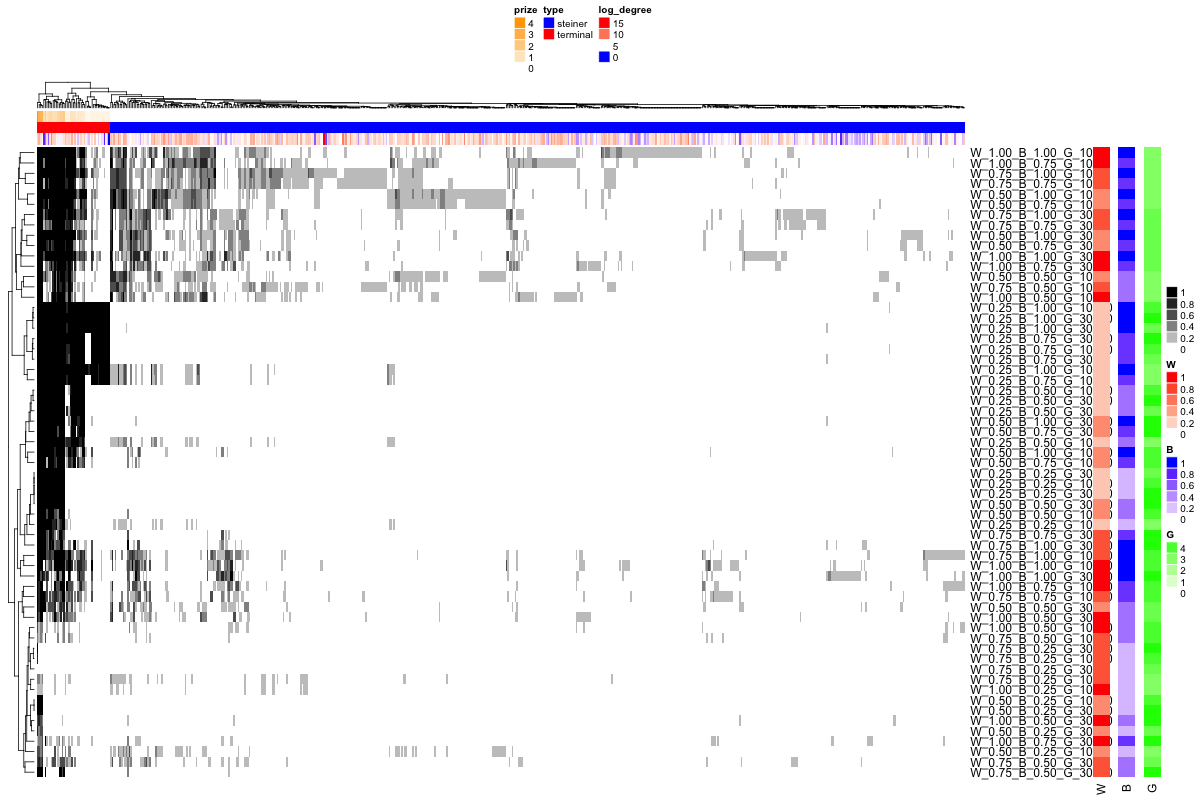

In [13]:
%%R -i robustness_df,node_attributes_df -w 1200 -h 800 -u px

plotHeatmap(robustness_df, node_attributes_df)

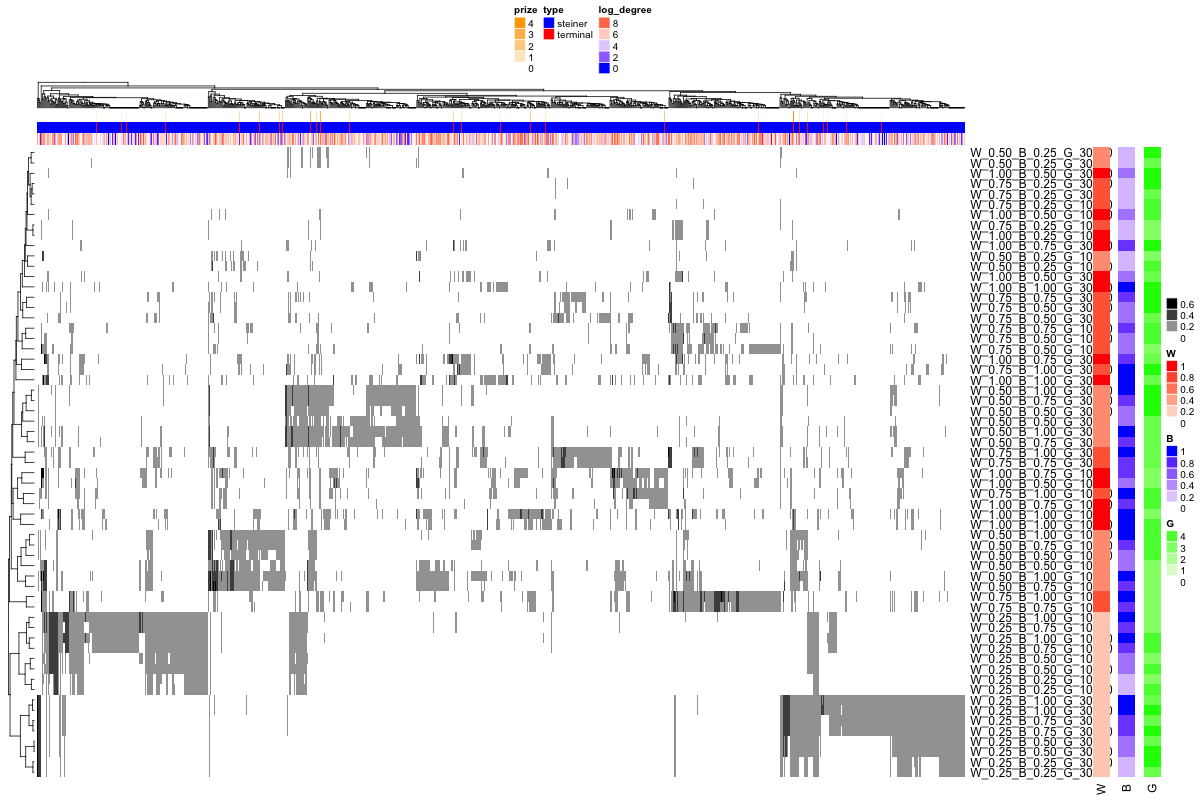

In [14]:
%%R -i specificity_df,node_attributes_df -w 1200 -h 800 -u px

plotHeatmap(specificity_df, node_attributes_df)

# 3. Output networkx graph for visualization

In [15]:
output_networkx_graph_as_graphml_for_cytoscape(results["W_0.25_B_0.50_G_10000"]["robust"], output_dir=output_dir, filename="W_0.25_B_0.50_G_10000.robust_network.graphml")

'/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/W_0.25_B_0.50_G_10000.robust_network.graphml'